In [1]:
from utils import read_jsonl, extract_nums, find_formula, extract_answer
import re
import numpy as np
import builtins
import matplotlib.pyplot as plt
import jsonlines
import json
import torch
from copy import deepcopy

def approx_eq(a, b):
    return abs(a - b) < 0.01

def approx_in(b, array):
    for a in array:
        if approx_eq(a, b):
            return True
    return False

def approx_overlap(a, b):
    count = 0
    a = {eval(var) for var in a}
    b = {eval(var) for var in b}
    for item in a:
        if approx_in(item, b):
            count += 1
    return count
    
def find_nums(string):
    return re.findall(r"\d*\.?\d+(?:/\d*\.?\d+)?", string)

In [2]:
# preprocess raw data
data = read_jsonl("grade-school-math/grade_school_math/data/test.jsonl")
for i in range(len(data)):
    item = data[i]
    ans = extract_answer(item['answer'])
    rationale, _ = item['answer'].split('####')
    rationale = rationale.strip().split("\n")    
    rationale = [var.strip() for var in rationale]
    item['rationale'] = rationale
    item['answer'] = ans
    
    ## --------------processing the formula to get leaf nums and non_leaf_nums -------------------
    leaf_nums = []
    non_leaf_nums = []
    
    for step in rationale:
        if step.count("<<") == 0:
            # no formula in this step - treat the last num as non_leaf_num
            nums = find_nums(step)
            if not nums:
                continue
            for num in nums[:-1]:
                if num in leaf_nums or num in non_leaf_nums:
                    continue
                # this num is a new leaf num
                leaf_nums.append(num)
            non_leaf_nums.append(nums[-1])
        elif step.count("<<") == 1:
            formula = find_formula(step)
            left, right = formula.split("=")
            left_nums = find_nums(left)
            
            # when "X/Y" is only num on the left, split them
            if len(left_nums) == 1 and "/" in left_nums[0]:
                left_nums = left_nums[0].split("/")
            
            for num in left_nums:
                if num in leaf_nums or num in non_leaf_nums:
                    continue
                # this num is a new leaf num
                leaf_nums.append(num)
            non_leaf_nums.append(right)
        else:
            # assert no step with >1 formulas
            assert False

    ## ------
    item['leaf_nums'] = leaf_nums
    item['non_leaf_nums'] = non_leaf_nums
    data[i] = item
    
# dictionary maps question to id
question2id = dict()
for i in range(len(data)):
    item = data[i]
    question2id[item['question']] = i

In [3]:
def main(file_path, return_depth=False):
    
    if file_path.endswith(".jsonl"):
        temp = read_jsonl(file_path)
        # last element is the prompt
        result, prompt = temp[:-1], temp[-1]
    else:
        with open(file_path, "r") as f:
            temp = json.load(f)
            # last element is the prompt
            result, prompt = temp[:-1], temp[-1]
    assert len(result) == 800
    
    non_leaf_coverage_l, non_leaf_precision_l, non_leaf_F1_l = [], [], []
    accuracy_l = []
    
    bins_non_leaf_coverage = dict()
    bins_non_leaf_precision = dict()
    bins_non_leaf_F1 = dict()
    bins_ans_accuracy = dict()
    
    count_no_nonleaf = 0
    for index in range(len(result)):
        predicted_item = result[index]
        data_entry = data[question2id[predicted_item['question']]]
        assert data_entry['question'] == predicted_item['question']

        for key_ in predicted_item.keys():
            if key_.startswith('ans_'):
                predicted_rationale = predicted_item[key_].split("Q:")[0].strip(" .")
                break
        setting_name = key_[4:]
        
        # get rid of in-token ",", artifact for long numbers
        predicted_rationale_tokens = predicted_rationale.split()
        for i in range(len(predicted_rationale_tokens)):
            token = predicted_rationale_tokens[i]
            if "," in token[1:-1]:
                token = token[0] + token[1:-1].replace(",","") + token[-1]
            predicted_rationale_tokens[i] = token
        predicted_rationale = " ".join(predicted_rationale_tokens)
        
        predicted_steps = predicted_rationale.split(". ")
        predicted_nonleaf_nums = set()
        for step in predicted_steps:
            if '=' in step:
                nums = find_nums(step)
                if nums:
                    predicted_nonleaf_nums.add(nums[-1])
        nums = find_nums(predicted_steps[-1])
        if nums:
            predicted_nonleaf_nums.add(nums[-1])
        
        non_leaf_nums = set(data_entry['non_leaf_nums'])
        
        # getrecall & precision & f1
        if not non_leaf_nums:
            count_no_nonleaf += 1
            non_leaf_coverage, non_leaf_precision = 1, 1
        else:
            non_leaf_overap = approx_overlap(predicted_nonleaf_nums, non_leaf_nums)
            non_leaf_coverage = non_leaf_overap/len(non_leaf_nums)
            if not predicted_nonleaf_nums:
                non_leaf_precision = 0
            else:
                non_leaf_precision = non_leaf_overap/len(predicted_nonleaf_nums)
            
        # f1
        if non_leaf_precision * non_leaf_coverage <= 0.01:
            non_leaf_F1 = 0
        else:
            non_leaf_F1 = 2 * non_leaf_precision * non_leaf_coverage / (non_leaf_precision + non_leaf_coverage)

        key = len(non_leaf_nums)   # depth of problem
        if key not in bins_non_leaf_coverage.keys():
            bins_non_leaf_coverage[key] = []
            bins_non_leaf_precision[key] = []
            bins_non_leaf_F1[key] = []
            bins_ans_accuracy[key] = []
            
        bins_non_leaf_coverage[key].append(non_leaf_coverage)
        bins_non_leaf_precision[key].append(non_leaf_precision)
        bins_non_leaf_F1[key].append(non_leaf_F1)
        
        # answer accuracy
        nums = extract_nums(predicted_rationale.split(". ")[-1])
        if nums and approx_eq(eval(data_entry['answer']),nums[-1]):
            ans_accuracy = 1
        else:
            ans_accuracy = 0
        bins_ans_accuracy[key].append(ans_accuracy)
        
        non_leaf_coverage_l.append(non_leaf_coverage)
        non_leaf_precision_l.append(non_leaf_precision)
        non_leaf_F1_l.append(non_leaf_F1)
        accuracy_l.append(ans_accuracy)
    
    print("setting:", setting_name)
    print("\taccuracy:", round(np.mean(accuracy_l), 3))
    if setting_name == 'standard':
        return
    
    print("\t"+str(count_no_nonleaf), "examples with no leaf or non-leaf")
    print("\taverage non-leaf num recall:", round(np.mean(non_leaf_coverage_l), 3))
    print("\taverage non-leaf num precision:", round(np.mean(non_leaf_precision_l), 3))
    print("\taverage non-leaf num F1:", round(np.mean(non_leaf_F1_l), 3))
    
    accuracy_depth = []
    coverage_depth = []
    precision_depth = []
    F1_depth = []
    count_depth = dict()
    for depth in range(1, 9):
        count_depth[depth] = len(bins_ans_accuracy[depth])
        accuracy_depth.append(np.mean(bins_ans_accuracy[depth]))
        coverage_depth.append(np.mean(bins_non_leaf_coverage[depth]))
        precision_depth.append(np.mean(bins_non_leaf_precision[depth]))
        F1_depth.append(np.mean(bins_non_leaf_F1[depth]))
    
    if return_depth:
        return accuracy_depth, coverage_depth, precision_depth, F1_depth, count_depth

In [4]:
main("result_gsm8k/gsm8k_CoT_original.engtext-davinci-002.sample800.seed1357.temp0.0..jsonl")

setting: CoT_original
	accuracy: 0.481
	0 examples with no leaf or non-leaf
	average non-leaf num recall: 0.445
	average non-leaf num precision: 0.588
	average non-leaf num F1: 0.487


In [5]:
main("result_gsm8k/gsm8k_standard.engtext-davinci-002.sample800.seed1357.temp0.0..jsonl")
accu_cot, cover_cot, prec_cot, f1_cot, count_depth = main(
    "result_gsm8k/gsm8k_chain_of_thought.engtext-davinci-002.sample800.seed1357.temp0.0..jsonl", return_depth=True)
accu_ir, cover_ir, prec_ir, f1_ir, count_depth = main(
    "result_gsm8k/gsm8k_invalid_reasoning.engtext-davinci-002.sample800.seed1357.temp0.0..jsonl", return_depth=True)
main("result_gsm8k/gsm8k_no_num_coherence.engtext-davinci-002.sample800.seed1357.temp0.0..jsonl")
main("result_gsm8k/gsm8k_no_num_relevance.engtext-davinci-002.sample800.seed1357.temp0.0..jsonl")
main("result_gsm8k/gsm8k_no_lang_coherence.engtext-davinci-002.sample800.seed1357.temp0.0..jsonl")
main("result_gsm8k/gsm8k_no_lang_relevance.engtext-davinci-002.sample800.seed1357.temp0.0..jsonl")
main("result_gsm8k/gsm8k_no_coherence.engtext-davinci-002.sample800.seed1357.temp0.0..jsonl")
main("result_gsm8k/gsm8k_no_relevance.engtext-davinci-002.sample800.seed1357.temp0.0..jsonl")

setting: standard
	accuracy: 0.154
setting: chain_of_thought
	accuracy: 0.485
	0 examples with no leaf or non-leaf
	average non-leaf num recall: 0.439
	average non-leaf num precision: 0.58
	average non-leaf num F1: 0.483
setting: invalid_reasoning
	accuracy: 0.395
	0 examples with no leaf or non-leaf
	average non-leaf num recall: 0.398
	average non-leaf num precision: 0.538
	average non-leaf num F1: 0.439
setting: no_num_coherency
	accuracy: 0.358
	0 examples with no leaf or non-leaf
	average non-leaf num recall: 0.353
	average non-leaf num precision: 0.481
	average non-leaf num F1: 0.392
setting: no_num_relevance
	accuracy: 0.275
	0 examples with no leaf or non-leaf
	average non-leaf num recall: 0.214
	average non-leaf num precision: 0.382
	average non-leaf num F1: 0.262
setting: no_lang_coherency
	accuracy: 0.258
	0 examples with no leaf or non-leaf
	average non-leaf num recall: 0.241
	average non-leaf num precision: 0.389
	average non-leaf num F1: 0.283
setting: no_lang_relevance
	a

In [6]:
main("result_gsm8k/gsm8k_standard.engtext-davinci-003.sample800.seed1357.temp0.0..jsonl")
main("result_gsm8k/gsm8k_chain_of_thought.engtext-davinci-003.sample800.seed1357.temp0.0..jsonl")
main("result_gsm8k/gsm8k_invalid_reasoning.engtext-davinci-003.sample800.seed1357.temp0.0..jsonl")
main("result_gsm8k/gsm8k_no_num_coherence.engtext-davinci-003.sample800.seed1357.temp0.0..jsonl")
main("result_gsm8k/gsm8k_no_num_relevance.engtext-davinci-003.sample800.seed1357.temp0.0..jsonl")
main("result_gsm8k/gsm8k_no_lang_coherence.engtext-davinci-003.sample800.seed1357.temp0.0..jsonl")
main("result_gsm8k/gsm8k_no_lang_relevance.engtext-davinci-003.sample800.seed1357.temp0.0..jsonl")
main("result_gsm8k/gsm8k_no_coherence.engtext-davinci-003.sample800.seed1357.temp0.0..jsonl")
main("result_gsm8k/gsm8k_no_relevance.engtext-davinci-003.sample800.seed1357.temp0.0..jsonl")

setting: standard
	accuracy: 0.152
setting: chain_of_thought
	accuracy: 0.545
	0 examples with no leaf or non-leaf
	average non-leaf num recall: 0.484
	average non-leaf num precision: 0.633
	average non-leaf num F1: 0.531
setting: invalid_reasoning
	accuracy: 0.515
	0 examples with no leaf or non-leaf
	average non-leaf num recall: 0.502
	average non-leaf num precision: 0.607
	average non-leaf num F1: 0.535
setting: no_num_coherence
	accuracy: 0.504
	0 examples with no leaf or non-leaf
	average non-leaf num recall: 0.465
	average non-leaf num precision: 0.622
	average non-leaf num F1: 0.515
setting: no_num_relevance
	accuracy: 0.472
	0 examples with no leaf or non-leaf
	average non-leaf num recall: 0.325
	average non-leaf num precision: 0.529
	average non-leaf num F1: 0.383
setting: no_lang_coherence
	accuracy: 0.419
	0 examples with no leaf or non-leaf
	average non-leaf num recall: 0.378
	average non-leaf num precision: 0.555
	average non-leaf num F1: 0.433
setting: no_lang_relevance
	

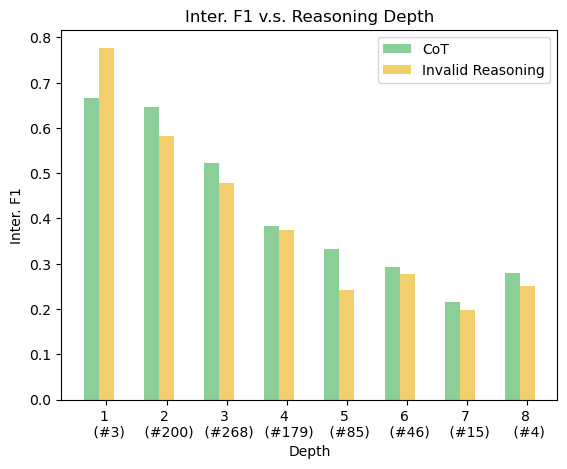

In [7]:
depth_range = list(range(1,9))
N = len(depth_range)
ind = np.arange(N) 
width = 0.25
  
xvals = f1_cot
bar1 = plt.bar(ind, xvals, width, color = '#8bce97')
  
yvals = f1_ir
bar2 = plt.bar(ind+width, yvals, width, color='#f3ce6c')
  
plt.xlabel("Depth")
plt.ylabel('Inter. F1')
plt.title("Inter. F1 v.s. Reasoning Depth")
  
plt.xticks(ind+width, ["{} \n (#{})".format(i, count_depth[i]) for i in depth_range])
plt.legend( (bar1, bar2), ('CoT', 'Invalid Reasoning') )
# plt.savefig("depth_split_2.png", bbox_inches='tight')
plt.show()